In [1]:
# %%
# Julia backend
from julia.api import Julia

jl = Julia(compiled_modules=False)
from julia import KitBase as kt
import numpy as np
import matplotlib.pyplot as plt

┌ Warning: Replacing docs for `SciMLBase.sol :: Union{Tuple, Tuple{D}, Tuple{S}, Tuple{N}, Tuple{T}} where {T, N, S, D}` in module `SciMLBase`
└ @ Base.Docs docs/Docs.jl:240
[ Info: Kinetic will run with 1 worker and 1 thread


In [2]:
p = [30, 15, 10, 10]

# %%
st = kt.Setup(space="1d1f3v", collision="fsm", interpOrder=1, boundary="period", maxTime=1.0)
ps = kt.PSpace1D(0.0, 1.0, p[0], 1)
vs = kt.VSpace3D(-8, 8, p[1], -8, 8, p[2], -8, 8, p[3])

# %%
knudsen = 1e-2
muref = kt.ref_vhs_vis(knudsen, 1.0, 0.5)
fsm = kt.fsm_kernel(vs, muref, 5, 1.0)
gas = kt.Gas(Kn=knudsen, K=0.0, fsm=fsm)
phi, psi, chi = kt.kernel_mode(
    5,
    vs.u1,
    vs.v1,
    vs.w1,
    vs.du[1, 1, 1],
    vs.dv[1, 1, 1],
    vs.dw[1, 1, 1],
    vs.nu,
    vs.nv,
    vs.nw,
    1.0,
)

In [11]:
# %%
def fw(x, p):
    ρ = 1 + 0.1 * np.sin(2 * np.pi * x)
    u = 1.0
    λ = ρ
    return kt.prim_conserve([ρ, u, 0, 0, λ], gas.γ)


def ff(x, p):
    w = fw(x, p)
    prim = kt.conserve_prim(w, gas.γ)
    return kt.maxwellian(vs.u, vs.v, vs.w, prim)


# %%
w = np.zeros((p[0], 5))
f = np.zeros(p)
df = np.zeros(p)
Q = np.zeros(p)
for i in range(p[0]):
    f[i, :, :, :] = ff(ps.x[i+1], None)
    w[i, :] = kt.moments_conserve(f[i, :, :, :], vs.u, vs.v, vs.w, vs.weights)

# %%
import copy

w0 = copy.deepcopy(w)

# %%
def compute_df(df, f, ps, vs):
    for i in range(1, ps.nx - 1):
        for j in range(1, vs.nu):
            if vs.u[j, 1, 1] > 0.0:
                df[i, j, :, :] = (f[i, j, :, :] - f[i - 1, j, :, :]) / ps.dx[i]
            else:
                df[i, j, :, :] = (f[i + 1, j, :, :] - f[i, j, :, :]) / ps.dx[i]

    for j in range(1, vs.nu):
        if vs.u[j, 1, 1] > 0.0:
            df[0, j, :, :] = (f[0, j, :, :] - f[ps.nx - 1, j, :, :]) / ps.dx[0]
            df[ps.nx - 1, j, :, :] = (f[ps.nx - 1, j, :, :] - f[ps.nx - 2, j, :, :]) / ps.dx[ps.nx - 1]
        else:
            df[0, j, :, :] = (f[1, j, :, :] - f[0, j, :, :]) / ps.dx[0]
            df[ps.nx - 1, j, :, :] = (f[0, j, :, :] - f[ps.nx - 1, j, :, :]) / ps.dx[ps.nx - 1]



# %%
def compute_Q(Q, f, ps, gas, phi, psi, chi, dt):
    # f = (x, u, v, w)
    for i in range(0, ps.nx):
        Q[i, :, :, :] = dt * kt.boltzmann_fft(f[i, :, :, :], gas.fsm.Kn, gas.fsm.nm, phi, psi, chi)


# %%
def step(f, df, Q, ps, vs, dt):
    for i in range(0, ps.nx):
        f[i, :, :, :] -= vs.u * df[i, :, :, :] * dt + Q[i, :, :, :]
        w[i, :] = kt.moments_conserve(f[i, :, :, :], vs.u, vs.v, vs.w, vs.weights)


# %%
dt = 1e-4
N = 200
for iter in range(N):
    compute_df(df, f, ps, vs)
    compute_Q(Q, f, ps, gas, phi, psi, chi, dt)
    step(f, df, Q, ps, vs, dt)
    print(iter + 1)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200


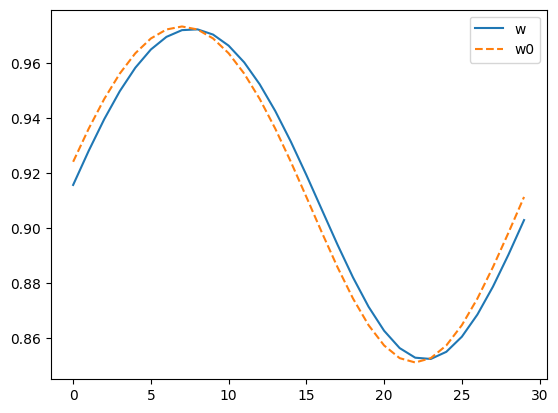

In [12]:
# %%
plt.plot(w[:, 1])
plt.plot(w0[:, 1], '--')
plt.legend(['w', 'w0'])
plt.savefig('sol_{}x{}.png'.format(dt, N), dpi = 500)
plt.show()
# %%